In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils

In [2]:
latent_dims = 10
num_epochs = 10
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = True

In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.28MB/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.57MB/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [19]:
# to-do
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = 64
        #
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c(64) x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: batch x 128 x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims) # dims = 10 디멘젼 10 벡터


    #그니깐, (batch, 128, 7, 7) -> 이걸 1차원 1-D vector로
    def forward(self, x):
         x = F.relu(self.conv1(x))
         x = F.relu(self.conv2(x))
         x = x.view(x.size(0), -1) # 평평하게~~ 1차원으로 핀다면? 즉, x.size(0) = batch 이니깐, batch size를 똑같게 맞춰주고 평평하게 해주는 과정임!
         #펴주는 과정
         x = self.fc(x)
         return x #batch= 10

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features = c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)


    def forward(self, x):
         x = self.fc(x)
         x = x.view(x.size(0), capacity*2,7,7) # 평평하게~~ 1차원으로 핀다면? 즉, x.size(0) = batch 이니깐, batch size를 똑같게 맞춰주고 평평하게 해주는 과정임!
         x = F.relu(self.conv2(x))
         x = torch.tanh(self.conv1(x))

         return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon


In [20]:
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 396171


In [21]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        # to-do
        # loss 를 mse로!!!
        loss = F.mse_loss(image_batch_recon, image_batch)
        #아니면, 이렇게 해도됨
        #loss = torch.sqrt((image_batch_recon, image_batch))


        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 10] average reconstruction error: 0.127183
Epoch [2 / 10] average reconstruction error: 0.074139
Epoch [3 / 10] average reconstruction error: 0.066323
Epoch [4 / 10] average reconstruction error: 0.062010
Epoch [5 / 10] average reconstruction error: 0.059127
Epoch [6 / 10] average reconstruction error: 0.057050
Epoch [7 / 10] average reconstruction error: 0.055547
Epoch [8 / 10] average reconstruction error: 0.054293
Epoch [9 / 10] average reconstruction error: 0.053213
Epoch [10 / 10] average reconstruction error: 0.052487


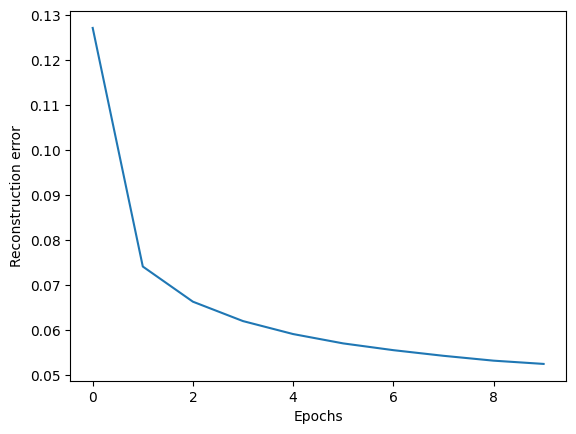

In [22]:
# loss plot

plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [ ]:
# 테스트셋에서 에러 측정

autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.052605


Original images


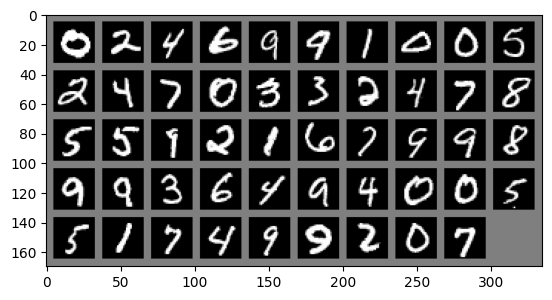

Autoencoder reconstruction:


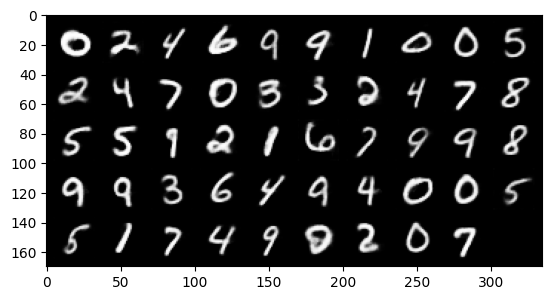

In [ ]:
# 테스트 셋에서 이미지 재구축

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

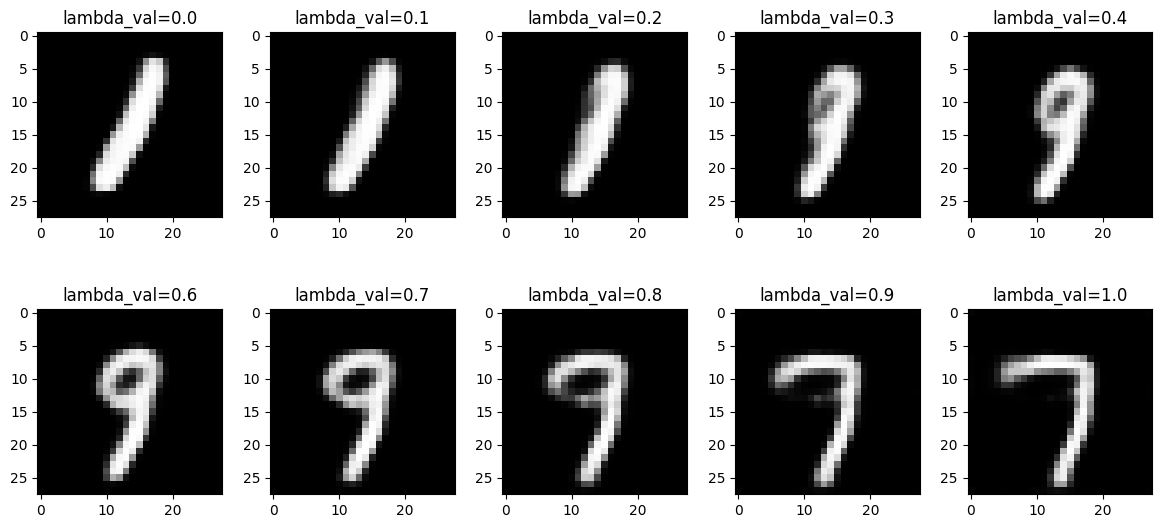

In [ ]:
# 두 latent vector간 interpolation

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

    return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), autoencoder, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show()

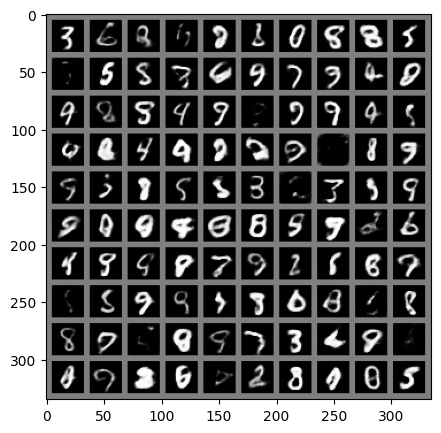

In [ ]:
# 무작위 latent vector에서의 재구축

with torch.no_grad():
    # approx. fit a multivariate Normal distribution (with diagonal cov.) to the latent vectors of a random part of the test set
    images, labels =  next(iter(test_dataloader))
    images = images.to(device)
    latent = autoencoder.encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims)*std + mean

    # reconstruct images from the latent vectors
    latent = latent.to(device)
    img_recon = autoencoder.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()